In [1]:
import aiohttp
import aiomoex
import random

from os.path import exists
from datetime import datetime
from typing import Callable

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.logger import configure
from finrl.agents.stablebaselines3.models import DRLAgent

import gymnasium as gym
from gymnasium import spaces
from gymnasium.utils import seeding

import os
import csv

%matplotlib inline

In [2]:
# mlflow.set_tracking_uri("http://localhost:5000")

In [3]:
START_DATE = '2022-05-01'
END_DATE = datetime.now().strftime('%Y-%m-%d')

In [4]:
async def fetch_moex_data(start_date=START_DATE, end_date=END_DATE, timeframe='H', ticker='SBER'):

    # –ú–∞–ø–ø–∏–Ω–≥ –∏–Ω—Ç–µ—Ä–≤–∞–ª–æ–≤
    interval_map = {'D': 24, 'W': 7, 'H': 60, 'M': 31, 'm': 1}
    interval = interval_map.get(timeframe, 60)
    print(f"üìä –ó–∞–≥—Ä—É–∂–∞–µ–º –¥–∞–Ω–Ω—ã–µ –¥–ª—è {ticker} —Å {start_date} –ø–æ {end_date} (—Ç–∞–π–º—Ñ—Ä–µ–π–º: {timeframe})")

    async with aiohttp.ClientSession() as session:
        # –ó–∞–ø—Ä–∞—à–∏–≤–∞–µ–º —Å–≤–µ—á–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ
        data = await aiomoex.get_market_candles(
            session,
            security=ticker,
            interval=interval,
            start=start_date,
            end=end_date
        )

    # –ü—Ä–æ–≤–µ—Ä—è–µ–º, –µ—Å—Ç—å –ª–∏ –¥–∞–Ω–Ω—ã–µ
    if not data:
        raise ValueError(f"‚ùå –ù–µ —É–¥–∞–ª–æ—Å—å –ø–æ–ª—É—á–∏—Ç—å –¥–∞–Ω–Ω—ã–µ –¥–ª—è {ticker}")

    # –°–æ–∑–¥–∞–µ–º DataFrame
    df = pd.DataFrame(data)

    df = df.rename(columns={'begin': 'date'})

    # –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –¥–∞—Ç—É –≤ datetime –∏ —Å—Ç–∞–≤–∏–º –∏–Ω–¥–µ–∫—Å
    df['date'] = pd.to_datetime(df['date'])
    # df.set_index('date', inplace=True)

    # –û—Å—Ç–∞–≤–ª—è–µ–º —Ç–æ–ª—å–∫–æ –Ω—É–∂–Ω—ã–µ —Å—Ç–æ–ª–±—Ü—ã
    df = df[['date', 'open', 'high', 'low', 'close', 'volume']]

    print(f"‚úÖ –ó–∞–≥—Ä—É–∂–µ–Ω–æ {len(df)} —Å–≤–µ—á–µ–π –¥–ª—è {ticker}")

    return df.sort_values('date')

# df = await fetch_moex_data(ticker="SBER", timeframe='H')
# df.to_csv('data.csv', index=False)
df = pd.read_csv('data.csv')
display(df.head())
print(df.info())

date    open    high     low   close    volume
0  2022-05-04 09:00:00  129.10  129.10  129.10  129.10    111560
1  2022-05-04 10:00:00  129.10  131.50  125.77  127.00  17793280
2  2022-05-04 11:00:00  127.05  127.50  123.60  123.95  13508120
3  2022-05-04 12:00:00  123.89  126.23  123.60  125.44   6536410
4  2022-05-04 13:00:00  125.44  126.21  124.61  125.35   3540730

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10714 entries, 0 to 10713
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    10714 non-null  object 
 1   open    10714 non-null  float64
 2   high    10714 non-null  float64
 3   low     10714 non-null  float64
 4   close   10714 non-null  float64
 5   volume  10714 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 502.3+ KB
None


In [5]:
### INDICATORS PARAMS ###

rsi_lenght = 9
ema_lenght = 21

In [6]:
def calc_rsi(over: pd.Series, fn_roll: Callable) -> pd.Series:

    delta = over.diff()
    up, down = delta.clip(lower=0), delta.clip(upper=0).abs()

    roll_up, roll_down = fn_roll(up), fn_roll(down)

    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))

    rsi[:] = np.select([roll_down == 0, roll_up == 0, True], [100, 0, rsi])
    rsi.name = 'rsi'

    valid_rsi = rsi[rsi_lenght - 1:]
    assert ((0 <= valid_rsi) & (valid_rsi <= 100)).all()
    return rsi

df.index = df['date']
df = df.drop(['date'], axis=1)

df['feature_upper_chanel'] = df['high'].rolling(window=20).max()
df['feature_lower_chanel'] = df['low'].rolling(window=20).min()

df['feature_rsi'] = calc_rsi(df['close'], lambda s: s.ewm(span=rsi_lenght).mean())
df['feature_rsi_ema'] = df['feature_rsi'].ewm(span=ema_lenght).mean()
df['tic'] = 'SBER'
df = df.dropna()
df.reset_index(inplace=True)

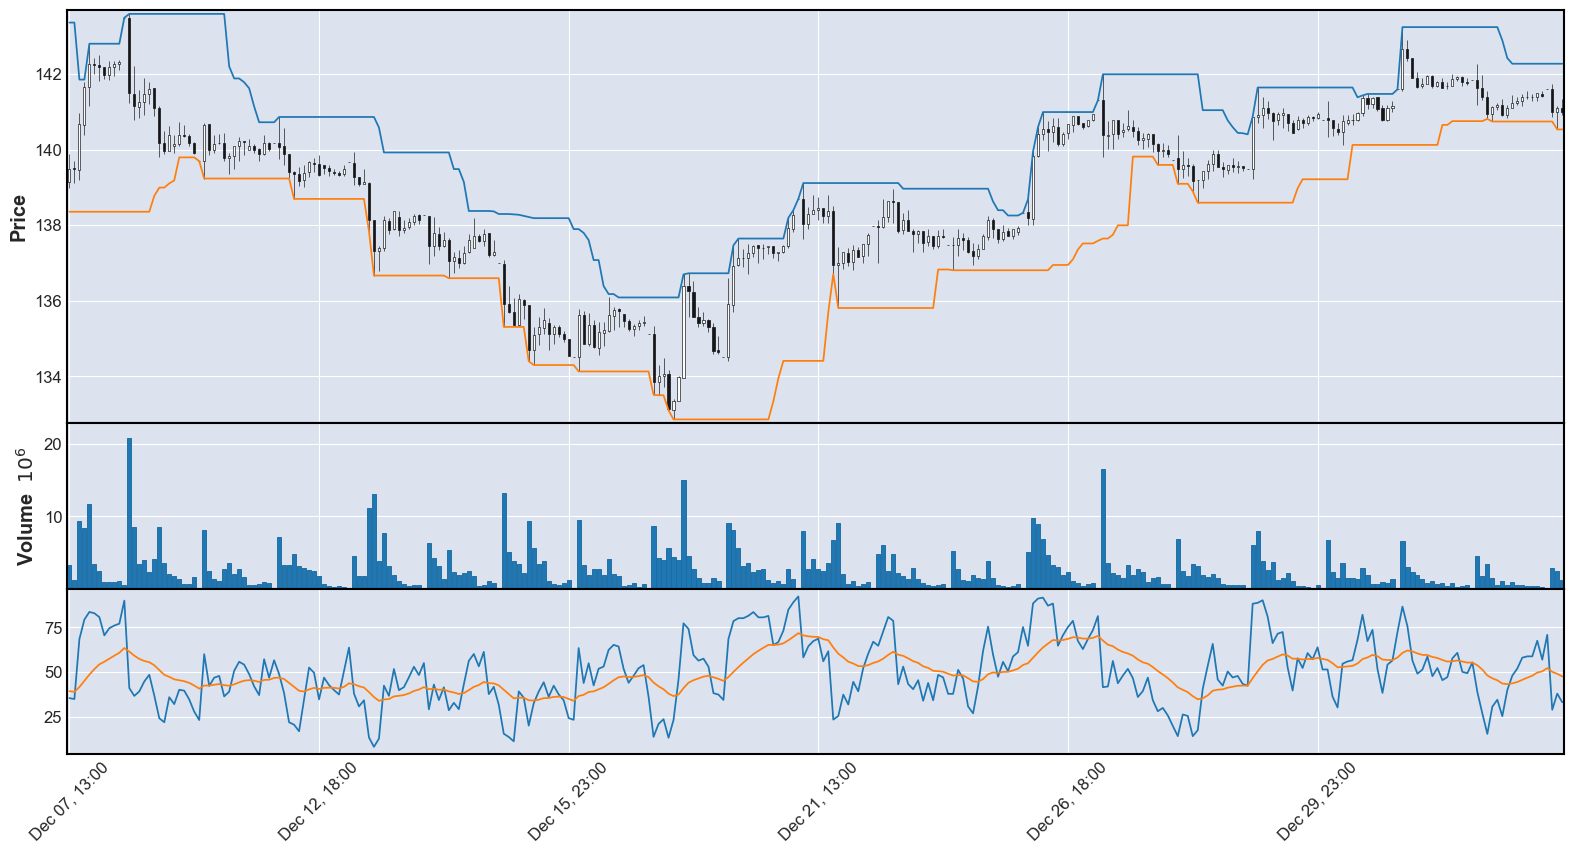

In [7]:
df_sample_for_plot = df.iloc[1800:2100]
df_sample_for_plot.index = df_sample_for_plot['date'].astype('datetime64[ns]')
df_sample_for_plot = df_sample_for_plot.drop(['date'], axis=1)

apdict = [mpf.make_addplot(df_sample_for_plot[['feature_upper_chanel', 'feature_lower_chanel']]), mpf.make_addplot(df_sample_for_plot[['feature_rsi', 'feature_rsi_ema']], panel=2)]
mpf.plot(df_sample_for_plot, type='candle', addplot=apdict, figratio=(14, 7), show_nontrading=False, volume=True, tight_layout=True,figscale=1.5)

plt.show()
plt.close()
# df_sample_for_plot

In [8]:
display(df.head())
print(df.shape)
print()
print(df.info())

date    open    high     low   close   volume  \
0  2022-05-05 18:00:00  124.30  124.80  124.25  124.80  2989720   
1  2022-05-06 09:00:00  124.74  124.74  124.74  124.74    43600   
2  2022-05-06 10:00:00  124.74  124.99  121.52  122.46  9430400   
3  2022-05-06 11:00:00  122.42  123.27  121.90  122.53  3760250   
4  2022-05-06 12:00:00  122.47  123.00  122.00  122.27  2522840   

   feature_upper_chanel  feature_lower_chanel  feature_rsi  feature_rsi_ema  \
0                131.50                122.50    65.137694        42.669720   
1                131.50                122.50    62.626662        44.800752   
2                127.50                121.52    22.120918        42.416804   
3                126.23                121.52    24.007184        40.508814   
4                126.21                121.52    21.580421        38.571720   

    tic  
0  SBER  
1  SBER  
2  SBER  
3  SBER  
4  SBER

(10695, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10695 entries, 0 to 10694
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  10695 non-null  object 
 1   open                  10695 non-null  float64
 2   high                  10695 non-null  float64
 3   low                   10695 non-null  float64
 4   close                 10695 non-null  float64
 5   volume                10695 non-null  int64  
 6   feature_upper_chanel  10695 non-null  float64
 7   feature_lower_chanel  10695 non-null  float64
 8   feature_rsi           10695 non-null  float64
 9   feature_rsi_ema       10695 non-null  float64
 10  tic                   10695 non-null  object 
dtypes: float64(8), int64(1), object(2)
memory usage: 919.2+ KB
None


In [ ]:
class StockTradingEnv(gym.Env):    
    # metadata = {"render.modes": ["human"]}

    def __init__(
            self,
            df,
            stock_dim,              # –†–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å (–∫–æ–ª–∏—á–µ—Å—Ç–≤–æ) –∞–∫—Ü–∏–π, –¥–æ—Å—Ç—É–ø–Ω—ã—Ö –¥–ª—è —Ç–æ—Ä–≥–æ–≤–ª–∏
            hmax,                   # –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∞–∫—Ü–∏–π, –∫–æ—Ç–æ—Ä—ã–µ –º–æ–∂–Ω–æ –∫—É–ø–∏—Ç—å/–ø—Ä–æ–¥–∞—Ç—å –∑–∞ –æ–¥–∏–Ω —à–∞–≥
            initial_amount,         # –ù–∞—á–∞–ª—å–Ω—ã–π –±–∞–ª–∞–Ω—Å (—Å—É–º–º–∞, —Å –∫–æ—Ç–æ—Ä–æ–π —Å—Ç–∞—Ä—Ç—É–µ—Ç –∞–≥–µ–Ω—Ç)
            buy_cost_pct,           # –ü—Ä–æ—Ü–µ–Ω—Ç –∫–æ–º–∏—Å—Å–∏–∏ –ø—Ä–∏ –ø–æ–∫—É–ø–∫–µ
            sell_cost_pct,          # –ü—Ä–æ—Ü–µ–Ω—Ç –∫–æ–º–∏—Å—Å–∏–∏ –ø—Ä–∏ –ø—Ä–æ–¥–∞–∂–µ
            reward_scaling,         # –ö–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç –º–∞—Å—à—Ç–∞–±–∏—Ä–æ–≤–∞–Ω–∏—è –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏—è            
            state_space,            # –†–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–∞ —Å–æ—Å—Ç–æ—è–Ω–∏–π
            action_space,           # –†–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–∞ –¥–µ–π—Å—Ç–≤–∏–π (—á–∏—Å–ª–æ –∞–∫—Ü–∏–π, –Ω–∞–¥ –∫–æ—Ç–æ—Ä—ã–º–∏ –¥–µ–π—Å—Ç–≤—É–µ–º)
            tech_indicator_list,    # –°–ø–∏—Å–æ–∫ —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏—Ö –∏–Ω–¥–∏–∫–∞—Ç–æ—Ä–æ–≤ –¥–ª—è –∞–Ω–∞–ª–∏–∑–∞ –∞–∫—Ü–∏–π
            turbulence_threshold=None,          # –ü–æ—Ä–æ–≥ —Ç—É—Ä–±—É–ª–µ–Ω—Ç–Ω–æ—Å—Ç–∏ —Ä—ã–Ω–∫–∞ –¥–ª—è –∏–∑–º–µ–Ω–µ–Ω–∏—è –ª–æ–≥–∏–∫–∏ —Å–¥–µ–ª–æ–∫ (–Ω–µ–æ–±—è–∑–∞—Ç–µ–ª—å–Ω–æ)
            risk_indicator_col="turbulence",    # –ù–∞–∑–≤–∞–Ω–∏–µ –∫–æ–ª–æ–Ω–∫–∏ —Å –ø–æ–∫–∞–∑–∞—Ç–µ–ª–µ–º —Ä–∏—Å–∫–∞/—Ç—É—Ä–±—É–ª–µ–Ω—Ç–Ω–æ—Å—Ç–∏
            make_plots=True,       # –§–ª–∞–≥: —Å—Ç—Ä–æ–∏—Ç—å –≥—Ä–∞—Ñ–∏–∫–∏ –ø–æ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º —Ç–æ—Ä–≥–æ–≤–ª–∏ –∏–ª–∏ –Ω–µ—Ç
            print_verbosity=10,     # –ß–∞—Å—Ç–æ—Ç–∞ –≤—ã–≤–æ–¥–∞ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏ –≤ –∫–æ–Ω—Å–æ–ª—å
            day=0,                  # –¢–µ–∫—É—â–∏–π –¥–µ–Ω—å (–∏–Ω–¥–µ–∫—Å –≤ –¥–∞–Ω–Ω—ã—Ö)
            initial=True,           # –§–ª–∞–≥, –æ–ø—Ä–µ–¥–µ–ª—è—é—â–∏–π, –∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è –ª–∏ –Ω–∞—á–∞–ª—å–Ω–æ–µ —Å–æ—Å—Ç–æ—è–Ω–∏–µ
            previous_state=[],      # –ü—Ä–µ–¥—ã–¥—É—â–µ–µ —Å–æ—Å—Ç–æ—è–Ω–∏–µ (–¥–ª—è –ø–µ—Ä–µ–¥–∞—á–∏ –º–µ–∂–¥—É —ç–ø–∏–∑–æ–¥–∞–º–∏, –µ—Å–ª–∏ –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ)
            model_name="",          # –ò–º—è –º–æ–¥–µ–ª–∏ (–∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è –ø—Ä–∏ —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–∏ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤)
            mode="",                # –†–µ–∂–∏–º —Ä–∞–±–æ—Ç—ã (–Ω–∞–ø—Ä–∏–º–µ—Ä, 'train' –∏–ª–∏ 'test')
            iteration="",           # –ò—Ç–µ—Ä–∞—Ü–∏—è –æ–±—É—á–µ–Ω–∏—è –∏–ª–∏ —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏—è
            rsi_on=False,           # –§–ª–∞–≥, —É–∫–∞–∑—ã–≤–∞—é—â–∏–π, –∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è –ª–∏ RSI –≤ —Ç–æ—Ä–≥–æ–≤–ª–µ (–Ω–µ–æ–±—è–∑–∞—Ç–µ–ª—å–Ω–æ)
            bonus_buy_reward=100,   # –ë–æ–Ω—É—Å–Ω–∞—è –∫–æ–º–∏—Å—Å–∏—è –ø—Ä–∏ –ø–æ–∫—É–ø–∫–µ (–Ω–µ–æ–±—è–∑–∞—Ç–µ–ª—å–Ω–æ)
            bonus_sell_reward=100,  # –ë–æ–Ω—É—Å–Ω–∞—è –∫–æ–º–∏—Å—Å–∏—è –ø—Ä–∏ –ø—Ä–æ–¥–∞–∂–µ (–Ω–µ–æ–±—è–∑–∞—Ç–µ–ª—å–Ω–æ)
            reward_window=14,       # –†–∞–∑–º–µ—Ä –æ–∫–Ω–∞ –¥–ª—è —Ä–∞—Å—á–µ—Ç–∞ –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏—è (–Ω–µ–æ–±—è–∑–∞—Ç–µ–ª—å–Ω–æ)
            actions_dead_zone_threshold=0.75,
            # enable_trade_penalty = False,   # –î–æ–±–∞–≤–ª–µ–Ω–∞ –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç—å –¥–æ–±–∞–≤–∏—Ç—å —à—Ç—Ä–∞—Ñ—ã –∑–∞ —á–∞—Å—Ç—É—é —Ç–æ—Ä–≥–æ–≤–ª—é
            # trade_penalty_window = 100     # –û–∫–Ω–æ –¥–ª—è —Ä–∞—Å—á–µ—Ç–∞ —à—Ç—Ä–∞—Ñ–æ–≤ –∑–∞ —á–∞—Å—Ç—É—é —Ç–æ—Ä–≥–æ–≤–ª—é
            ):        
        
        self.day = day                                      # –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –Ω–æ–º–µ—Ä–∞ —Ç–µ–∫—É—â–µ–≥–æ –¥–Ω—è
        self.df = df                                        # –°–æ—Ö—Ä–∞–Ω—è–µ–º –ø–µ—Ä–µ–¥–∞–Ω–Ω—ã–π DataFrame —Å –¥–∞–Ω–Ω—ã–º–∏        
        self.stock_dim = stock_dim                          # –†–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å (–∫–æ–ª–∏—á–µ—Å—Ç–≤–æ) –∞–∫—Ü–∏–π        
        self.hmax = hmax                                    # –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∞–∫—Ü–∏–π –¥–ª—è —Å–¥–µ–ª–∫–∏       
        self.initial_amount = initial_amount                # –ù–∞—á–∞–ª—å–Ω—ã–π –±–∞–ª–∞–Ω—Å –∞–≥–µ–Ω—Ç–∞        
        self.buy_cost_pct = buy_cost_pct                    # –ö–æ–º–∏—Å—Å–∏—è –ø—Ä–∏ –ø–æ–∫—É–ø–∫–µ (–≤ –ø—Ä–æ—Ü–µ–Ω—Ç–∞—Ö)        
        self.sell_cost_pct = sell_cost_pct                  # –ö–æ–º–∏—Å—Å–∏—è –ø—Ä–∏ –ø—Ä–æ–¥–∞–∂–µ (–≤ –ø—Ä–æ—Ü–µ–Ω—Ç–∞—Ö)        
        self.reward_scaling = reward_scaling                # –ö–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç –º–∞—Å—à—Ç–∞–±–∏—Ä–æ–≤–∞–Ω–∏—è –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏—è        
        self.state_space = state_space                      # –†–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–∞ —Å–æ—Å—Ç–æ—è–Ω–∏–π        
        self.action_space = action_space                    # –†–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–∞ –¥–µ–π—Å—Ç–≤–∏–π (–∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∞–∫—Ç–∏–≤–æ–≤)        
        self.tech_indicator_list = tech_indicator_list      # –°–ø–∏—Å–æ–∫ —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏—Ö –∏–Ω–¥–∏–∫–∞—Ç–æ—Ä–æ–≤           
        self.data = self.df.loc[self.day, :]                # –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∏—Ä—É–µ–º –¥–∞–Ω–Ω—ã–µ –¥–ª—è —Ç–µ–∫—É—â–µ–≥–æ –¥–Ω—è (–≤—ã–±–∏—Ä–∞–µ–º —Å—Ç—Ä–æ–∫—É –ø–æ –∏–Ω–¥–µ–∫—Å—É day)        
        self.terminal = False                               # –§–ª–∞–≥ —Ç–µ—Ä–º–∏–Ω–∞–ª—å–Ω–æ–≥–æ —Å–æ—Å—Ç–æ—è–Ω–∏—è (–∫–æ–Ω–µ—Ü –¥–∞–Ω–Ω—ã—Ö)        
        self.make_plots = make_plots                        # –§–ª–∞–≥ –¥–ª—è –ø–æ—Å—Ç—Ä–æ–µ–Ω–∏—è –≥—Ä–∞—Ñ–∏–∫–æ–≤, –µ—Å–ª–∏ –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ        
        self.print_verbosity = print_verbosity              # –ß–∞—Å—Ç–æ—Ç–∞ –≤—ã–≤–æ–¥–∞ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏        
        self.turbulence_threshold = turbulence_threshold    # –ü–æ—Ä–æ–≥ —Ç—É—Ä–±—É–ª–µ–Ω—Ç–Ω–æ—Å—Ç–∏ –¥–ª—è –∏–∑–º–µ–Ω–µ–Ω–∏—è –ø–æ–≤–µ–¥–µ–Ω–∏—è —Ç–æ—Ä–≥–æ–≤–ª–∏ (–µ—Å–ª–∏ –∑–∞–¥–∞–Ω)        
        self.risk_indicator_col = risk_indicator_col        # –ù–∞–∑–≤–∞–Ω–∏–µ –∫–æ–ª–æ–Ω–∫–∏ —Å –ø–æ–∫–∞–∑–∞—Ç–µ–ª–µ–º —Ä–∏—Å–∫–∞        
        self.initial = initial                              # –§–ª–∞–≥, –∏—Å–ø–æ–ª—å–∑—É–µ–º—ã–π –¥–ª—è –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –∏–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏–∏ —Å–æ—Å—Ç–æ—è–Ω–∏—è        
        self.previous_state = previous_state                # –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –ø—Ä–µ–¥—ã–¥—É—â–µ–≥–æ —Å–æ—Å—Ç–æ—è–Ω–∏—è (–µ—Å–ª–∏ –∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è)        
        self.model_name = model_name                        # –ò–º—è –º–æ–¥–µ–ª–∏ –¥–ª—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤        
        self.mode = mode                                    # –†–µ–∂–∏–º —Ä–∞–±–æ—Ç—ã (–Ω–∞–ø—Ä–∏–º–µ—Ä, 'train' –∏–ª–∏ 'test')        
        self.iteration = iteration                          # –ò—Ç–µ—Ä–∞—Ü–∏—è –æ–±—É—á–µ–Ω–∏—è/—Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏—è        
        self.state = self._initiate_state()                 # –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∏—Ä—É–µ–º —Å–æ—Å—Ç–æ—è–Ω–∏–µ —Å—Ä–µ–¥—ã —Å –ø–æ–º–æ—â—å—é –≤—Å–ø–æ–º–æ–≥–∞—Ç–µ–ª—å–Ω–æ–≥–æ –º–µ—Ç–æ–¥–∞
        self.reward = 0                                     # –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö –¥–ª—è —Ä–∞—Å—á–µ—Ç–∞ –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏—è
        self.turbulence = 0                                 # , —Ç—É—Ä–±—É–ª–µ–Ω—Ç–Ω–æ—Å—Ç–∏
        self.cost = 0                                       # , —Å—Ç–æ–∏–º–æ—Å—Ç–∏ —Å–¥–µ–ª–æ–∫
        self.trades = 0                                     # , –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ —Å–¥–µ–ª–æ–∫.
        self.episode = 0                                    # –°—á–µ—Ç—á–∏–∫ —ç–ø–∏–∑–æ–¥–æ–≤        
        self.asset_memory = [self.initial_amount]           # –°–ø–∏—Å–æ–∫ –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –∏—Å—Ç–æ—Ä–∏–∏ –∏–∑–º–µ–Ω–µ–Ω–∏—è –±–∞–ª–∞–Ω—Å–∞ (–∞–∫—Ç–∏–≤–æ–≤)        
        self.rewards_memory = []                            # –°–ø–∏—Å–æ–∫ –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –∏—Å—Ç–æ—Ä–∏–∏ –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–π        
        self.actions_memory = []                            # –°–ø–∏—Å–æ–∫ –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –∏—Å—Ç–æ—Ä–∏–∏ –¥–µ–π—Å—Ç–≤–∏–π
        self.reward_buffer = []                             # –±—É—Ñ–µ—Ä –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –Ω–µ–¥–∞–≤–Ω–∏—Ö –º–≥–Ω–æ–≤–µ–Ω–Ω—ã—Ö –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–π        
        self.date_memory = [self._get_date()]               # –°–ø–∏—Å–æ–∫ –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –¥–∞—Ç (–Ω–∞—á–∏–Ω–∞–µ—Ç—Å—è —Å –¥–∞—Ç—ã –ø–µ—Ä–≤–æ–≥–æ —à–∞–≥–∞)        
        self._seed()                                        # –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –≥–µ–Ω–µ—Ä–∞—Ç–æ—Ä–∞ —Å–ª—É—á–∞–π–Ω—ã—Ö —á–∏—Å–µ–ª
        self.reward_window = reward_window                  # –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —à–∞–≥–æ–≤ –¥–ª—è —Å–∫–æ–ª—å–∑—è—â–µ–π —Å—Ä–µ–¥–Ω–µ–π –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏—è
        self.reward_buffer = []                             # –±—É—Ñ–µ—Ä –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –Ω–µ–¥–∞–≤–Ω–∏—Ö –º–≥–Ω–æ–≤–µ–Ω–Ω—ã—Ö –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–π
        self.actions_dead_zone_threshold = actions_dead_zone_threshold                              # –ø–æ—Ä–æ–≥ –∞–∫—Ç–∏–≤–Ω–æ—Å—Ç–∏, –Ω–∏–∂–µ –∫–æ—Ç–æ—Ä–æ–≥–æ –¥–µ–π—Å—Ç–≤–∏—è –±—É–¥—É—Ç –∏–≥–Ω–æ—Ä–∏—Ä–æ–≤–∞—Ç—å—Å—è.
        self.bonus_buy_reward = bonus_buy_reward
        self.bonus_sell_reward = bonus_sell_reward
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))                  # –û–ø—Ä–µ–¥–µ–ª—è–µ–º –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–æ –¥–µ–π—Å—Ç–≤–∏–π –∫–∞–∫ Box (–≤—Å–µ –¥–µ–π—Å—Ç–≤–∏—è –æ—Ç -1 –¥–æ 1)        
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.state_space,))    # –û–ø—Ä–µ–¥–µ–ª—è–µ–º –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–æ –Ω–∞–±–ª—é–¥–µ–Ω–∏–π (—Å–æ—Å—Ç–æ—è–Ω–∏–π) –∫–∞–∫ Box —Å –Ω–µ–æ–≥—Ä–∞–Ω–∏—á–µ–Ω–Ω—ã–º–∏ –∑–Ω–∞—á–µ–Ω–∏—è–º–∏        
        # self.enable_trade_penalty = enable_trade_penalty    # –§–ª–∞–≥ –≤–∫–ª—é—á–µ–Ω–∏—è —à—Ç—Ä–∞—Ñ–∞ –∑–∞ —á–∞—Å—Ç—ã–µ –æ–ø–µ—Ä–∞—Ü–∏–∏
        # self.trade_penalty_window = trade_penalty_window    # –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —à–∞–≥–æ–≤ –¥–ª—è —Ä–∞—Å—á—ë—Ç–∞ —à—Ç—Ä–∞—Ñ–∞
        self.trades_history = []                            # –ë—É—Ñ–µ—Ä –¥–ª—è –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ —Å–¥–µ–ª–æ–∫ –∑–∞ –∫–∞–∂–¥—ã–π —à–∞–≥
        self.last_trades_count = 0                          # –ó–∞–ø–æ–º–∏–Ω–∞–µ–º, —Å–∫–æ–ª—å–∫–æ —Å–¥–µ–ª–æ–∫ –±—ã–ª–æ –¥–æ —Ç–µ–∫—É—â–µ–≥–æ —à–∞–≥–∞
        self.rsi_on = rsi_on
        self.cumulative_reward_list = []                   # —Å–ø–∏—Å–æ–∫ –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –Ω–∞–∫–æ–ø–ª–µ–Ω–Ω—ã—Ö –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–π –∑–∞ –∫–∞–∂–¥—ã–π —ç–ø–∏–∑–æ–¥
        self.random_n = random.randint(1000000, 9999999)   # —Å–ª—É—á–∞–π–Ω–æ–µ —á–∏—Å–ª–æ –¥–ª—è —É–Ω–∏–∫–∞–ª—å–Ω–æ—Å—Ç–∏

    def render(self, mode="human", close=False):        
        return self.state
    

    def _seed(self, seed=None):       
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    
    def get_sb_env(self):        
        env = DummyVecEnv([lambda: self])
        obs = env.reset()
        return env, obs
    

    def _get_date(self):   
        return self.data['date']
    

    def save_asset_memory(self):  # –°–æ—Ö—Ä–∞–Ω—è–µ–º –∏—Å—Ç–æ—Ä–∏—é –±–∞–ª–∞–Ω—Å–∞ (–∞–∫—Ç–∏–≤–æ–≤) –≤ DataFrame 
        return pd.DataFrame({"date": self.date_memory, "account_value": self.asset_memory})
    

    def save_action_memory(self): # –°–æ—Ö—Ä–∞–Ω—è–µ–º –∏—Å—Ç–æ—Ä–∏—é –¥–µ–π—Å—Ç–≤–∏–π –≤ DataFrame
        date_list = self.date_memory[:-1]
        action_list = self.actions_memory
        df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _initiate_state(self):
        if self.initial:
            state = (
                [self.initial_amount]  # –ù–∞—á–∞–ª—å–Ω—ã–π –∫–∞–ø–∏—Ç–∞–ª
                + [self.data['close']]    # –¢–µ–∫—É—â–∞—è —Ü–µ–Ω–∞ –∞–∫—Ç–∏–≤–∞ 
                + [0]*self.stock_dim   # –°–ø–∏—Å–æ–∫ –∏–∑ –Ω—É–ª–µ–π, –¥–ª–∏–Ω–∞ –∫–æ—Ç–æ—Ä–æ–≥–æ —Ä–∞–≤–Ω–∞ –∫–æ–ª–∏—á–µ—Å—Ç–≤—É –∞–∫—Ü–∏–π (–∏–ª–∏ —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç–∏ –∞–∫—Ç–∏–≤–∞) - –ù–∞ —Å—Ç–∞—Ä—Ç–µ, –µ—Å–ª–∏ –Ω–∞—á–∞–ª—å–Ω–æ–µ —Å–æ—Å—Ç–æ—è–Ω–∏–µ, –∞–≥–µ–Ω—Ç –Ω–µ –≤–ª–∞–¥–µ–µ—Ç –Ω–∏–∫–∞–∫–∏–º–∏ –∞–∫—Ü–∏—è–º–∏, –ø–æ—ç—Ç–æ–º—É –∑–∞–ø–æ–ª–Ω—è–µ—Ç—Å—è –Ω—É–ª—è–º–∏.
                + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])  # –ó–Ω–∞—á–µ–Ω–∏—è –≤—Å–µ—Ö —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏—Ö –∏–Ω–¥–∏–∫–∞—Ç–æ—Ä–æ–≤.
                )           
        else:
            state = (
                [self.previous_state[0]]    # –ë–∞–ª–∞–Ω—Å, –∫–æ—Ç–æ—Ä—ã–π –∞–≥–µ–Ω—Ç –∏–º–µ–ª –Ω–∞ –ø—Ä–æ—à–ª–æ–º —à–∞–≥–µ
                + [self.data['close']]         # –¢–µ–∫—É—â–∞—è —Ü–µ–Ω–∞ –∞–∫—Ç–∏–≤–∞ 
                + self.previous_state[ (self.stock_dim + 1) : (self.stock_dim * 1 + 1) ]  # –°—Ä–µ–∑, –∫–æ—Ç–æ—Ä—ã–π –¥–æ–ª–∂–µ–Ω —Å–æ–¥–µ—Ä–∂–∞—Ç—å –¥–∞–Ω–Ω—ã–µ –æ –∫–æ–ª–∏—á–µ—Å—Ç–≤–µ –∞–∫—Ü–∏–π –∞–≥–µ–Ω—Ç–∞ - —Ç–µ–∫—É—â–∞—è –ø–æ–∑–∏—Ü–∏—è.
                + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])       # –ó–Ω–∞—á–µ–Ω–∏—è –≤—Å–µ—Ö —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏—Ö –∏–Ω–¥–∏–∫–∞—Ç–æ—Ä–æ–≤.
                )
            
        return state
    
    def reset(self, seed=None, **kwargs):
        if seed:
            self._seed(seed)

        self.state = self._initiate_state()

        if self.initial:
            self.asset_memory = [self.initial_amount]               # –ò—Å—Ç–æ—Ä–∏—è –∞–∫—Ç–∏–≤–æ–≤ –Ω–∞—á–∏–Ω–∞–µ—Ç—Å—è —Å –Ω–∞—á–∞–ª—å–Ω–æ–≥–æ –∫–∞–ø–∏—Ç–∞–ª–∞
        else:
            previous_total_asset = (
                self.previous_state[0]                              # –ë–∞–ª–∞–Ω—Å —Å—Ä–µ–¥—Å—Ç–≤ (–¥–µ–Ω—å–≥–∏) –∞–≥–µ–Ω—Ç–∞ –Ω–∞ –º–æ–º–µ–Ω—Ç –ø—Ä–µ–¥—ã–¥—É—â–µ–≥–æ —à–∞–≥–∞
                + sum(
                    np.array(self.state[1 : (self.stock_dim + 1)])  # –¢–µ–∫—É—â–∏–µ —Ü–µ–Ω—ã –∞–∫—Ç–∏–≤–æ–≤ (–Ω–∞–ø—Ä–∏–º–µ—Ä, –∑–∞–∫—Ä—ã—Ç–∏—è) –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∏–∑ –∞–∫—Ç–∏–≤–æ–≤
                    * np.array(self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])  # –î–∞–Ω–Ω—ã–µ –æ –∫–æ–ª–∏—á–µ—Å—Ç–≤–µ –∞–∫—Ü–∏–π, –∫–æ—Ç–æ—Ä—ã–º–∏ –≤–ª–∞–¥–µ–µ—Ç –∞–≥–µ–Ω—Ç –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∞–∫—Ç–∏–≤–∞
                    ) # * –ü–µ—Ä–µ–º–Ω–æ–∂–∞—é—Ç—Å—è - –≤—ã—á–∏—Å–ª—è–µ—Ç—Å—è —Ä—ã–Ω–æ—á–Ω–∞—è —Å—Ç–æ–∏–º–æ—Å—Ç—å –∞–∫—Ç–∏–≤–æ–≤ (—Ü–µ–Ω–∞ √ó –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ).
                )     # sum —Å—É–º–º–∏—Ä—É–µ—Ç —Å—Ç–æ–∏–º–æ—Å—Ç—å –∞–∫—Ç–∏–≤–æ–≤ —Å –±–∞–ª–∞–Ω—Å–æ–º –ø–æ—Ä—Ç—Ñ–µ–ª—è
            self.asset_memory = [previous_total_asset] # C–æ—Ö—Ä–∞–Ω—è–µ—Ç –Ω–∞—á–∞–ª—å–Ω–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ –±–∞–ª–∞–Ω—Å–∞ –¥–∞–Ω–Ω–æ–≥–æ —ç–ø–∏–∑–æ–¥–∞ (–Ω–∞–ª–∏—á–Ω—ã–µ —Å—Ä–µ–¥—Å—Ç–≤–∞ + —Å—Ç–æ–∏–º–æ—Å—Ç—å –∞–∫—Ç–∏–≤–æ–≤).

        # –°–±—Ä–∞—Å—ã–≤–∞–µ–º —Å—á–µ—Ç—á–∏–∫ –¥–Ω—è, –¥–∞–Ω–Ω—ã–µ, —Ç—É—Ä–±—É–ª–µ–Ω—Ç–Ω–æ—Å—Ç—å, –∑–∞—Ç—Ä–∞—Ç—ã –∏ —Å–¥–µ–ª–∫–∏
        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        # –°–±—Ä–∞—Å—ã–≤–∞–µ–º –∏—Å—Ç–æ—Ä–∏—é –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–π, –¥–µ–π—Å—Ç–≤–∏–π –∏ –¥–∞—Ç
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        # –£–≤–µ–ª–∏—á–∏–≤–∞–µ–º —Å—á–µ—Ç—á–∏–∫ —ç–ø–∏–∑–æ–¥–æ–≤
        self.episode += 1

        return self.state, {}    

    
    def _update_state(self):
        state = (
            [self.state[0]]                        # –ë–∞–ª–∞–Ω—Å –∞–≥–µ–Ω—Ç–∞
            + [self.data['close']]                 # –û–±–æ—Ä–∞—á–∏–≤–∞–µ–º —Ü–µ–Ω—É –∑–∞–∫—Ä—ã—Ç–∏—è –≤ —Å–ø–∏—Å–æ–∫
            + list(self.state[(self.stock_dim + 1):(self.stock_dim * 2 + 1)])  # –ü–æ–∑–∏—Ü–∏–∏ –ø–æ –∞–∫—Ç–∏–≤–∞–º
            + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])  # –¢–µ—Ö–Ω–∏—á–µ—Å–∫–∏–µ –∏–Ω–¥–∏–∫–∞—Ç–æ—Ä—ã
        )
        return state
    

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1  # –ü—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞ –¥–æ—Å—Ç–∏–∂–µ–Ω–∏–µ –∫–æ–Ω—Ü–∞ –¥–∞–Ω–Ω—ã—Ö

        if self.terminal:  # –ï—Å–ª–∏ –¥–æ—Å—Ç–∏–≥–Ω—É—Ç –∫–æ–Ω–µ—Ü –¥–∞–Ω–Ω—ã—Ö

            current_price = np.array( self.state[1 : (self.stock_dim + 1)] )  # –¢–µ–∫—É—â–∏–µ —Ü–µ–Ω—ã –∞–∫—Ç–∏–≤–∞
            current_pos = np.array( self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)] )  # –¢–µ–∫—É—â–∏–µ –ø–æ–∑–∏—Ü–∏–∏ –∞–∫—Ç–∏–≤–∞
            end_total_asset = self.state[0] + sum(current_price * current_pos)            
            tot_reward = (self.state[0] + sum(current_price * current_pos) - self.initial_amount) # –ß–∏—Å—Ç–∞—è –ø—Ä–∏–±—ã–ª—å (–∏–ª–∏ —É–±—ã—Ç–æ–∫) –∫ –Ω–∞—á–∞–ª—å–Ω–æ–º—É –∫–∞–ø–∏—Ç–∞–ª—É

            df_total_value = pd.DataFrame(self.asset_memory)  # DataFrame —Å –∏—Å—Ç–æ—Ä–∏–µ–π –∏–∑–º–µ–Ω–µ–Ω–∏—è –±–∞–ª–∞–Ω—Å–∞
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory # –î–æ–±–∞–≤–ª—è–µ–º –¥–∞—Ç—ã –≤ DataFrame
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(1) # –í—ã—á–∏—Å–ª—è–µ–º –µ–∂–µ–¥–Ω–µ–≤–Ω—ã–π –¥–æ—Ö–æ–¥
            if df_total_value["daily_return"].std() != 0:
                sharpe = ((252 ** 0.5) * df_total_value["daily_return"].mean() / df_total_value["daily_return"].std()) # –°—á–∏—Ç–∞–µ–º –®–∞—Ä–ø-–∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç
            
            if self.rewards_memory:
                df_rewards = pd.DataFrame(self.rewards_memory, columns=["account_rewards"])
                self.write_cumulative_reward(f'./logs/rewards/rewards_{END_DATE}_{self.random_n}.csv', sum(self.rewards_memory))         # !!!!!!!!!!!!!!
            else:
                df_rewards = pd.DataFrame(columns=["account_rewards"])
            df_rewards["date"] = self.date_memory[:-1] # –î–æ–±–∞–≤–ª—è–µ–º –¥–∞—Ç—ã –≤ DataFrame

            # –í—ã–≤–æ–¥ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏ –ø–æ —ç–ø–∏–∑–æ–¥—É —Å –∑–∞–¥–∞–Ω–Ω–æ–π —á–∞—Å—Ç–æ—Ç–æ–π (print_verbosity)
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")
                print("---------------------------------")

            # –ï—Å–ª–∏ –∑–∞–¥–∞–Ω—ã –∏–º—è –º–æ–¥–µ–ª–∏ –∏ —Ä–µ–∂–∏–º, —Å–æ—Ö—Ä–∞–Ω—è–µ–º –∏—Å—Ç–æ—Ä–∏—é –¥–µ–π—Å—Ç–≤–∏–π –∏ –∑–Ω–∞—á–µ–Ω–∏–π
            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(f"results/actions_{self.mode}_{self.model_name}_{self.iteration}.csv")                
                df_total_value.to_csv(f"results/account_value_{self.mode}_{self.model_name}_{self.iteration}.csv")
                df_rewards.to_csv(f"results/account_rewards_{self.mode}_{self.model_name}_{self.iteration}.csv")
                plt.plot(self.asset_memory, "r")
                # plt.savefig(f"results/account_value_{self.mode}_{self.model_name}_{self.iteration}.png", index=False)
                plt.savefig(f"results/account_value_{self.mode}_{self.model_name}_{self.iteration}.png")

                plt.close()

            return self.state, self.reward, self.terminal, False, {}
        

        else: # –ï—Å–ª–∏ –µ—â–µ –Ω–µ –¥–æ—Å—Ç–∏–≥–Ω—É—Ç –∫–æ–Ω–µ—Ü –¥–∞–Ω–Ω—ã—Ö
            # actions = np.where(np.abs(actions) < self.actions_dead_zone_threshold, 0, actions) # !!!
            actions = actions * self.hmax       # –ü—Ä–∏–≤–æ–¥–∏–º –¥–µ–π—Å—Ç–≤–∏—è –∫ —Ü–µ–ª–æ—á–∏—Å–ª–µ–Ω–Ω–æ–º—É —Ç–∏–ø—É (—Ç–∞–∫ –∫–∞–∫ –Ω–µ–ª—å–∑—è –∫—É–ø–∏—Ç—å/–ø—Ä–æ–¥–∞—Ç—å –¥—Ä–æ–±–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∞–∫—Ü–∏–π)
            actions = actions.astype(int)

            if self.turbulence_threshold:       # –ï—Å–ª–∏ –ø–æ—Ä–æ–≥ —Ç—É—Ä–±—É–ª–µ–Ω—Ç–Ω–æ—Å—Ç–∏ –∑–∞–¥–∞–Ω –∏ —Ç—É—Ä–±—É–ª–µ–Ω—Ç–Ω–æ—Å—Ç—å –ø—Ä–µ–≤—ã—à–∞–µ—Ç –ø–æ—Ä–æ–≥, –∑–∞–¥–∞–µ–º –ø—Ä–∏–Ω—É–¥–∏—Ç–µ–ª—å–Ω—É—é –ø—Ä–æ–¥–∞–∂—É
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)

            current_price = np.array( self.state[1 : (self.stock_dim + 1)] )                       # –¢–µ–∫—É—â–∏–µ —Ü–µ–Ω—ã –∞–∫—Ç–∏–≤–∞
            current_pos = np.array( self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)] )  # –¢–µ–∫—É—â–∏–µ –ø–æ–∑–∏—Ü–∏–∏ –∞–∫—Ç–∏–≤–∞
            begin_total_asset = self.state[0] + sum(current_price * current_pos)                   # –°—É–º–º–∏—Ä—É–µ–º –≤—Å–µ –∑–Ω–∞—á–µ–Ω–∏—è –¥–ª—è –ø–æ–ª—É—á–µ–Ω–∏—è –Ω–∞—á–∞–ª—å–Ω–æ–≥–æ –∫–∞–ø–∏—Ç–∞–ª–∞ –∞–≥–µ–Ω—Ç–∞

            argsort_actions = np.argsort(actions)                                   # –°–æ—Ä—Ç–∏—Ä—É–µ–º –∏–Ω–¥–µ–∫—Å—ã –¥–µ–π—Å—Ç–≤–∏–π –ø–æ –∏—Ö –≤–µ–ª–∏—á–∏–Ω–µ
            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]       # –û–ø—Ä–µ–¥–µ–ª—è–µ–º –∏–Ω–¥–µ–∫—Å—ã –¥–ª—è –ø—Ä–æ–¥–∞–∂–∏ (–æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã–µ –¥–µ–π—Å—Ç–≤–∏—è)
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]  # –û–ø—Ä–µ–¥–µ–ª—è–µ–º –∏–Ω–¥–µ–∫—Å—ã –¥–ª—è –ø–æ–∫—É–ø–∫–∏ (–ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω—ã–µ –¥–µ–π—Å—Ç–≤–∏—è)
            
            for index in sell_index:             # –í—ã–ø–æ–ª–Ω—è–µ–º –æ–ø–µ—Ä–∞—Ü–∏–∏ –ø—Ä–æ–¥–∞–∂–∏ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∞–∫—Ç–∏–≤–∞
                actions[index] = self._sell_stock(index, actions[index]) * (-1)

            for index in buy_index:              # –í—ã–ø–æ–ª–Ω—è–µ–º –æ–ø–µ—Ä–∞—Ü–∏–∏ –ø–æ–∫—É–ø–∫–∏ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∞–∫—Ç–∏–≤–∞
                actions[index] = self._buy_stock(index, actions[index])            

            self.actions_memory.append(actions)  # –°–æ—Ö—Ä–∞–Ω—è–µ–º –∏—Å—Ç–æ—Ä–∏—é –¥–µ–π—Å—Ç–≤–∏–π            

            self.day += 1                        # –ü–µ—Ä–µ—Ö–æ–¥–∏–º –∫ —Å–ª–µ–¥—É—é—â–µ–º—É –¥–Ω—é
            self.data = self.df.loc[self.day, :] # –ü–æ–ª—É—á–∞–µ–º –¥–∞–Ω–Ω—ã–µ –¥–ª—è –Ω–æ–≤–æ–≥–æ –¥–Ω—è
            if self.turbulence_threshold:
                self.turbulence = self.data[self.risk_indicator_col].values[0]

            self.state = self._update_state()    # –û–±–Ω–æ–≤–ª—è–µ–º —Å–æ—Å—Ç–æ—è–Ω–∏–µ —Å —É—á–µ—Ç–æ–º –Ω–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö

            end_total_asset = (                  # –í—ã—á–∏—Å–ª—è–µ–º –±–∞–ª–∞–Ω—Å –ø–æ—Å–ª–µ —Å–æ–≤–µ—Ä—à–µ–Ω–∏—è –¥–µ–π—Å—Ç–≤–∏–π
                self.state[0]
                + sum(
                    np.array( self.state[1 : (self.stock_dim + 1)] )
                    * np.array( self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)] )
                    )
                )
            self.asset_memory.append(end_total_asset)         # –°–æ—Ö—Ä–∞–Ω—è–µ–º –±–∞–ª–∞–Ω—Å –ø–æ—Å–ª–µ —Å–æ–≤–µ—Ä—à–µ–Ω–∏—è –¥–µ–π—Å—Ç–≤–∏–π
            self.date_memory.append(self._get_date())         # –°–æ—Ö—Ä–∞–Ω—è–µ–º –¥–∞—Ç—É —Ç–µ–∫—É—â–µ–≥–æ —Å–æ—Å—Ç–æ—è–Ω–∏—è

            ### –í–´–ß–ò–°–õ–ï–ù–ò–ï –í–û–ó–ù–ê–ì–†–ê–ñ–î–ï–ù–ò–Ø ###
            self.reward = end_total_asset - begin_total_asset # –í—ã—á–∏—Å–ª—è–µ–º –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–µ –∑–∞ —Å–æ–≤–µ—Ä—à–µ–Ω–Ω—ã–µ –¥–µ–π—Å—Ç–≤–∏—è
            self.reward = self.reward * self.reward_scaling   # –ú–∞—Å—à—Ç–∞–±–∏—Ä—É–µ–º –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–µ
            
            ## !!!!!!!!!!!!!!!!!!! ### –í–´–ß–ò–°–õ–ï–ù–ò–ï –î–ò–ù–ê–ú–ò–ß–ï–°–ö–û–ì–û –®–¢–†–ê–§–ê –ó–ê –ß–ê–°–¢–£–Æ –¢–û–†–ì–û–í–õ–Æ
            # trades_this_step = self.trades - self.last_trades_count 
            # self.last_trades_count = self.trades
            # self.trades_history.append(trades_this_step)
            # if len(self.trades_history) > self.trade_penalty_window:
            #     self.trades_history.pop(0)
            
            # if self.enable_trade_penalty:
            #     trade_count = sum(self.trades_history)
            #     dynamic_penalty = trade_count / self.trade_penalty_window  # –ù–∞–ø—Ä–∏–º–µ—Ä, 1 —Å–¥–µ–ª–∫–∞ -> ~0.01, 100 —Å–¥–µ–ª–æ–∫ -> 1.0
            #     self.reward -= dynamic_penalty
            ## !!!!!!!!!!!!!!!!!!! ### !!!!!!!!!!!!!!!!!!!!!!!!!!! ###

            self.rewards_memory.append(self.reward)

            return self.state, self.reward, self.terminal, False, {}
        
    def write_cumulative_reward(self, filename, cumulative_reward):
        # –ï—Å–ª–∏ —Ñ–∞–π–ª —Å—É—â–µ—Å—Ç–≤—É–µ—Ç, –¥–æ–ø–∏—Å—ã–≤–∞–µ–º –Ω–æ–≤—É—é —Å—Ç—Ä–æ–∫—É
        if os.path.exists(filename):
            with open(filename, 'a', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow([cumulative_reward])
        else:
            # –ï—Å–ª–∏ —Ñ–∞–π–ª –Ω–µ —Å—É—â–µ—Å—Ç–≤—É–µ—Ç, —Å–æ–∑–¥–∞—ë–º –µ–≥–æ —Å –∑–∞–≥–æ–ª–æ–≤–∫–æ–º –∏ –ø–µ—Ä–≤–æ–π —Å—Ç—Ä–æ–∫–æ–π
            with open(filename, 'w', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(["cumulative reward"])
                writer.writerow([cumulative_reward])

    

    def _buy_stock(self, index, action):

        def _do_buy():
            # –ü—Ä–æ–≤–µ—Ä—è–µ–º, —á—Ç–æ —Ü–µ–Ω–∞ –∞–∫—Ü–∏–∏ –ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω–∞
            if self.state[index + 1] > 0:
                available_amount = self.state[0] // self.state[index + 1]
                buy_num_shares = min(available_amount, action)
                buy_amount = self.state[index + 1] * buy_num_shares * (1 + self.buy_cost_pct)
            else:
                buy_num_shares = 0
                buy_amount = 0

            # –ï—Å–ª–∏ –ø–æ–∫—É–ø–∫–∞ —Å–æ–≤–µ—Ä—à–µ–Ω–∞, –æ–±–Ω–æ–≤–ª—è–µ–º –±–∞–ª–∞–Ω—Å, –ø–æ–∑–∏—Ü–∏—é, –∑–∞—Ç—Ä–∞—Ç—ã –∏ —Å—á—ë—Ç—á–∏–∫ —Å–¥–µ–ª–æ–∫
            if buy_num_shares > 0:
                self.state[0] -= buy_amount
                self.state[index + self.stock_dim + 1] += buy_num_shares
                self.cost += self.state[index + 1] * buy_num_shares * self.buy_cost_pct
                self.trades += 1

            return buy_num_shares

        # –ï—Å–ª–∏ —Ç—É—Ä–±—É–ª–µ–Ω—Ç–Ω–æ—Å—Ç—å –Ω–µ –ø—Ä–µ–≤—ã—à–∞–µ—Ç –ø–æ—Ä–æ–≥ (–∏–ª–∏ –ø–æ—Ä–æ–≥ –Ω–µ –∑–∞–¥–∞–Ω) ‚Äì —Å–æ–≤–µ—Ä—à–∞–µ–º –ø–æ–∫—É–ø–∫—É
        if self.turbulence_threshold is None or self.turbulence < self.turbulence_threshold:
            buy_num_shares = _do_buy()
        else:
            buy_num_shares = 0

        return buy_num_shares    

    def _sell_stock(self, index, action):

        def _do_sell_normal():        
            if self.state[index + 1] > 0:                                                              # –ü—Ä–æ–≤–µ—Ä–∫–∞: –µ—Å–ª–∏ —Ü–µ–Ω–∞ –∞–∫—Ü–∏–π –ø–æ –¥–∞–Ω–Ω–æ–º—É –∏–Ω–¥–µ–∫—Å—É –±–æ–ª—å—à–µ 0 (—Ç.–µ. –¥–∞–Ω–Ω—ã–µ –ø—Ä–∏—Å—É—Ç—Å—Ç–≤—É—é—Ç)
                if self.state[index + self.stock_dim + 1] > 0:                                         # –ü—Ä–æ–≤–µ—Ä–∫–∞: –µ—Å–ª–∏ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∞–∫—Ü–∏–π –Ω–∞ —Å—á–µ—Ç—É –±–æ–ª—å—à–µ 0                    
                    sell_num_shares = min(abs(action), self.state[index + self.stock_dim + 1])         # –í—ã—á–∏—Å–ª—è–µ–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∞–∫—Ü–∏–π –¥–ª—è –ø—Ä–æ–¥–∞–∂–∏: –º–∏–Ω–∏–º–∞–ª—å–Ω–æ–µ –º–µ–∂–¥—É –∞–±—Å–æ–ª—é—Ç–Ω—ã–º –∑–Ω–∞—á–µ–Ω–∏–µ–º action –∏ –¥–æ—Å—Ç—É–ø–Ω—ã–º–∏ –∞–∫—Ü–∏—è–º–∏
                    sell_amount = (self.state[index + 1] * sell_num_shares * (1 - self.sell_cost_pct)) # –í—ã—á–∏—Å–ª—è–µ–º —Å—É–º–º—É, –ø–æ–ª—É—á–µ–Ω–Ω—É—é –æ—Ç –ø—Ä–æ–¥–∞–∂–∏ —Å —É—á–µ—Ç–æ–º –∫–æ–º–∏—Å—Å–∏–∏                    
                    self.state[0] += sell_amount                                                       # –û–±–Ω–æ–≤–ª—è–µ–º –±–∞–ª–∞–Ω—Å, –¥–æ–±–∞–≤–ª—è—è —Å—É–º–º—É –ø—Ä–æ–¥–∞–∂–∏                    
                    self.state[index + self.stock_dim + 1] -= sell_num_shares                          # –í—ã—á–∏—Ç–∞–µ–º –ø—Ä–æ–¥–∞–Ω–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∞–∫—Ü–∏–π –∏–∑ –ø–æ—Ä—Ç—Ñ–µ–ª—è                    
                    self.cost += (self.state[index + 1] * sell_num_shares * self.sell_cost_pct)        # –£–≤–µ–ª–∏—á–∏–≤–∞–µ–º –∑–∞—Ç—Ä–∞—Ç—ã –Ω–∞ –∫–æ–º–∏—Å—Å–∏—é                    
                    self.trades += 1                                                                   # –£–≤–µ–ª–∏—á–∏–≤–∞–µ–º —Å—á–µ—Ç—á–∏–∫ —Å–¥–µ–ª–æ–∫
                else:                    
                    sell_num_shares = 0                                                                # –ï—Å–ª–∏ –∞–∫—Ü–∏–π –Ω–µ–¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ, –ø—Ä–æ–¥–∞–∂–∞ –Ω–µ –ø—Ä–æ–∏–∑–≤–æ–¥–∏—Ç—Å—è
            else:
                sell_num_shares = 0
            
            return sell_num_shares  # –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–æ–¥–∞–Ω–Ω—ã—Ö –∞–∫—Ü–∏–π        
        
        if self.turbulence_threshold:                                               # –ï—Å–ª–∏ –ø–æ—Ä–æ–≥ —Ç—É—Ä–±—É–ª–µ–Ω—Ç–Ω–æ—Å—Ç–∏ –∑–∞–¥–∞–Ω
            if self.turbulence >= self.turbulence_threshold:                        # –ò –µ—Å–ª–∏ –æ–Ω –±–æ–ª—å—à–µ –∑–∞–¥–∞–Ω–Ω–æ–≥–æ –ø–æ—Ä–æ–≥–∞ - –º–µ–Ω—è–µ–º —Å—Ç—Ä–∞—Ç–µ–≥–∏—é –ø—Ä–æ–¥–∞–∂–∏
                if self.state[index + 1] > 0:                                       # –ï—Å–ª–∏ —Ü–µ–Ω–∞ –±–æ–ª—å—à–µ 0, –ø—Ä–æ–≤–æ–¥–∏–º –æ–ø–µ—Ä–∞—Ü–∏—é –ø—Ä–æ–¥–∞–∂–∏ –≤—Å–µ—Ö –¥–æ—Å—Ç—É–ø–Ω—ã—Ö –∞–∫—Ü–∏–π
                    if self.state[index + self.stock_dim + 1] > 0:                        
                        sell_num_shares = self.state[index + self.stock_dim + 1]    # –ü—Ä–æ–¥–∞–µ–º –≤—Å–µ –∞–∫—Ü–∏–∏ –¥–∞–Ω–Ω–æ–≥–æ –∞–∫—Ç–∏–≤–∞
                        sell_amount = (self.state[index + 1] * sell_num_shares * (1 - self.sell_cost_pct))
                        self.state[0] += sell_amount                        
                        self.state[index + self.stock_dim + 1] = 0                  # –û–±–Ω—É–ª—è–µ–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∞–∫—Ü–∏–π –ø–æ—Å–ª–µ –ø—Ä–æ–¥–∞–∂–∏
                        self.cost += (self.state[index + 1] * sell_num_shares * self.sell_cost_pct)
                        self.trades += 1                                            # –£–≤–µ–ª–∏—á–∏–≤–∞–µ–º —Å—á–µ—Ç—á–∏–∫ —Å–¥–µ–ª–æ–∫
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:                
                sell_num_shares = _do_sell_normal()                                 # –ï—Å–ª–∏ —Ç—É—Ä–±—É–ª–µ–Ω—Ç–Ω–æ—Å—Ç—å –Ω–∏–∂–µ –ø–æ—Ä–æ–≥–∞, –≤—ã–ø–æ–ª–Ω—è–µ–º —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω—É—é –ø—Ä–æ–¥–∞–∂—É
        else:            
            sell_num_shares = _do_sell_normal()                                     # –ï—Å–ª–∏ –ø–æ—Ä–æ–≥ —Ç—É—Ä–±—É–ª–µ–Ω—Ç–Ω–æ—Å—Ç–∏ –Ω–µ –∑–∞–¥–∞–Ω, –≤—ã–ø–æ–ª–Ω—è–µ–º —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω—É—é –ø—Ä–æ–¥–∞–∂—É

        return sell_num_shares        # –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–æ–¥–∞–Ω–Ω—ã—Ö –∞–∫—Ü–∏–π (—Å –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã–º –∑–Ω–∞–∫–æ–º –¥–ª—è —É—á–µ—Ç–∞ –Ω–∞–ø—Ä–∞–≤–ª–µ–Ω–∏—è –¥–µ–π—Å—Ç–≤–∏—è)    

In [ ]:
# actions = np.where(np.abs(actions) < self.actions_dead_zone_threshold, 0, actions) # !!!
# actions = actions * self.hmax       # –ü—Ä–∏–≤–æ–¥–∏–º –¥–µ–π—Å—Ç–≤–∏—è –∫ —Ü–µ–ª–æ—á–∏—Å–ª–µ–Ω–Ω–æ–º—É —Ç–∏–ø—É (—Ç–∞–∫ –∫–∞–∫ –Ω–µ–ª—å–∑—è –∫—É–ø–∏—Ç—å/–ø—Ä–æ–¥–∞—Ç—å –¥—Ä–æ–±–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∞–∫—Ü–∏–π)
# actions = actions.astype(int)

# if self.turbulence_threshold:       # –ï—Å–ª–∏ –ø–æ—Ä–æ–≥ —Ç—É—Ä–±—É–ª–µ–Ω—Ç–Ω–æ—Å—Ç–∏ –∑–∞–¥–∞–Ω –∏ —Ç—É—Ä–±—É–ª–µ–Ω—Ç–Ω–æ—Å—Ç—å –ø—Ä–µ–≤—ã—à–∞–µ—Ç –ø–æ—Ä–æ–≥, –∑–∞–¥–∞–µ–º –ø—Ä–∏–Ω—É–¥–∏—Ç–µ–ª—å–Ω—É—é –ø—Ä–æ–¥–∞–∂—É
#     if self.turbulence >= self.turbulence_threshold:
#         actions = np.array([-self.hmax] * self.stock_dim)

# current_price = np.array( self.state[1 : (self.stock_dim + 1)] )                       # –¢–µ–∫—É—â–∏–µ —Ü–µ–Ω—ã –∞–∫—Ç–∏–≤–∞
# current_pos = np.array( self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)] )  # –¢–µ–∫—É—â–∏–µ –ø–æ–∑–∏—Ü–∏–∏ –∞–∫—Ç–∏–≤–∞
# begin_total_asset = self.state[0] + sum(current_price * current_pos)                   # –°—É–º–º–∏—Ä—É–µ–º –≤—Å–µ –∑–Ω–∞—á–µ–Ω–∏—è –¥–ª—è –ø–æ–ª—É—á–µ–Ω–∏—è –Ω–∞—á–∞–ª—å–Ω–æ–≥–æ –∫–∞–ø–∏—Ç–∞–ª–∞ –∞–≥–µ–Ω—Ç–∞

# argsort_actions = np.argsort(actions)                                   # –°–æ—Ä—Ç–∏—Ä—É–µ–º –∏–Ω–¥–µ–∫—Å—ã –¥–µ–π—Å—Ç–≤–∏–π –ø–æ –∏—Ö –≤–µ–ª–∏—á–∏–Ω–µ
# sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]       # –û–ø—Ä–µ–¥–µ–ª—è–µ–º –∏–Ω–¥–µ–∫—Å—ã –¥–ª—è –ø—Ä–æ–¥–∞–∂–∏ (–æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã–µ –¥–µ–π—Å—Ç–≤–∏—è)
# buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]  # –û–ø—Ä–µ–¥–µ–ª—è–µ–º –∏–Ω–¥–µ–∫—Å—ã –¥–ª—è –ø–æ–∫—É–ø–∫–∏ (–ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω—ã–µ –¥–µ–π—Å—Ç–≤–∏—è)

# for index in sell_index:             # –í—ã–ø–æ–ª–Ω—è–µ–º –æ–ø–µ—Ä–∞—Ü–∏–∏ –ø—Ä–æ–¥–∞–∂–∏ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∞–∫—Ç–∏–≤–∞
#     actions[index] = self._sell_stock(index, actions[index]) * (-1)

# for index in buy_index:              # –í—ã–ø–æ–ª–Ω—è–µ–º –æ–ø–µ—Ä–∞—Ü–∏–∏ –ø–æ–∫—É–ø–∫–∏ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∞–∫—Ç–∏–≤–∞
#     actions[index] = self._buy_stock(index, actions[index])            

# self.actions_memory.append(actions)  # –°–æ—Ö—Ä–∞–Ω—è–µ–º –∏—Å—Ç–æ—Ä–∏—é –¥–µ–π—Å—Ç–≤–∏–π  

In [128]:
# actions = 0.5
# actions = 0.7
# actions = 0.92
# actions = 1
# actions = -1
# actions = -0.2
actions = np.array([0.8])
actions_dead_zone_threshold = 0
hmax = 100
price = 176
capital = 1000000

position = 50

actions = np.where(np.abs(actions) < actions_dead_zone_threshold, 0, actions)

if position == 0:
    if actions > 0:
        actions = actions * hmax
        actions = actions.astype(int)
    else:
        actions = np.array([0])
else:
    if actions < 0:
        actions = np.array([position]) * (-1)
    else:
        actions = np.array([0])


begin_total_asset = capital + sum(price * [position])
argsort_actions = np.argsort(actions)

sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]       # –û–ø—Ä–µ–¥–µ–ª—è–µ–º –∏–Ω–¥–µ–∫—Å—ã –¥–ª—è –ø—Ä–æ–¥–∞–∂–∏ (–æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã–µ –¥–µ–π—Å—Ç–≤–∏—è)
buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]  # –û–ø—Ä–µ–¥–µ–ª—è–µ–º –∏–Ω–¥–µ–∫—Å—ã –¥–ª—è –ø–æ–∫—É–ø–∫–∏ (–ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω—ã–µ –¥–µ–π—Å—Ç–≤–∏—è)
do_nothing_index = argsort_actions[: np.where(actions == 0)[0].shape[0]]  # –ò–Ω–¥–µ–∫—Å—ã, –≥–¥–µ –¥–µ–π—Å—Ç–≤–∏—è —Ä–∞–≤–Ω—ã –Ω—É–ª—é
print(f"sell_index: {sell_index}")
print(f"buy_index: {buy_index}")
print(f"do_nothing_index: {do_nothing_index}")
print(f"actions: {actions}")

sell_index: []
buy_index: []
do_nothing_index: [0]
actions: [0]


In [ ]:
ratio_list = ['feature_upper_chanel', 'feature_lower_chanel', 'feature_rsi', 'feature_rsi_ema']
stock_dimension = len(df['tic'].unique())
state_space = 1 + 2*stock_dimension + len(ratio_list) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

In [ ]:
# –ü–∞—Ä–∞–º–µ—Ç—Ä—ã —Å—Ä–µ–¥—ã (–º–æ–¥–µ–ª–∏ —Ä—ã–Ω–∫–∞)
env_kwargs = {
        "hmax": 10, 
        "initial_amount": 100000, 
        "buy_cost_pct": 0.003,
        "sell_cost_pct": 0.003,
        "state_space": state_space, 
        "stock_dim": stock_dimension, 
        "tech_indicator_list": ratio_list, 
        "action_space": stock_dimension, 
        # "reward_scaling": 1e-4,
        "reward_scaling": 1e3,
        "model_name": "ppo",
        "mode": "train",
        # "bonus_buy_reward": 10000,
        # "bonus_sell_reward": 1000,
        # "one_paper_mode": True,
        # "actions_dead_zone_threshold": 0.1,
        # "enable_trade_penalty": False,
        # "trade_penalty_window": 10,
    }

ppo_params = {
        "n_steps": 2024,
        "ent_coef": 0.01,
        "learning_rate": 0.00025,
        "batch_size": 128,
        "device": "cpu",
        "gamma": 0.999
    }

env, _ = StockTradingEnv(df = df, **env_kwargs).get_sb_env()
agent = DRLAgent(env = env)
model_ppo = agent.get_model("ppo", model_kwargs = ppo_params)

# set up logger
tmp_path = 'results' + '/ppo'
new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])

# Set new logger
model_ppo.set_logger(new_logger_ppo)

In [ ]:
class EpisodeRewardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []        # –≤—Ä–µ–º–µ–Ω–Ω—ã–π –±—É—Ñ–µ—Ä –¥–ª—è –Ω–∞–≥—Ä–∞–¥ —Ç–µ–∫—É—â–µ–≥–æ —ç–ø–∏–∑–æ–¥–∞
        self.cumulative_rewards = []     # –∏—Ç–æ–≥–æ–≤—ã–π —Å–ø–∏—Å–æ–∫ –∫—É–º—É–ª—è—Ç–∏–≤–Ω—ã—Ö –Ω–∞–≥—Ä–∞–¥ –ø–æ —ç–ø–∏–∑–æ–¥–∞–º

    def _on_step(self) -> bool:
        # –ü–æ–ª—É—á–∞–µ–º –Ω–∞–≥—Ä–∞–¥—É —Ç–µ–∫—É—â–µ–≥–æ —à–∞–≥–∞. –ï—Å–ª–∏ –∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è –≤–µ–∫—Ç–æ—Ä–∏–∑–æ–≤–∞–Ω–Ω–∞—è —Å—Ä–µ–¥–∞, –≤–æ–∑—å–º–µ–º –ø–µ—Ä–≤–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ.
        reward = self.locals.get("rewards", None)
        if reward is not None:
            self.episode_rewards.append(reward[0])
        return True

    def _on_rollout_end(self) -> None:
        # –ü–æ –æ–∫–æ–Ω—á–∞–Ω–∏–∏ rollout'–∞ —Å—á–∏—Ç–∞–µ–º —Å—É–º–º–∞—Ä–Ω—É—é –Ω–∞–≥—Ä–∞–¥—É –∑–∞ —ç–ø–∏–∑–æ–¥
        cumulative_reward = sum(self.episode_rewards)
        self.cumulative_rewards.append(cumulative_reward)
        self.logger.record("episode/cumulative_reward", cumulative_reward)
        print(f"Episode cumulative reward: {cumulative_reward}")
        # –û—á–∏—â–∞–µ–º –±—É—Ñ–µ—Ä –¥–ª—è —Å–ª–µ–¥—É—é—â–µ–≥–æ —ç–ø–∏–∑–æ–¥–∞
        self.episode_rewards = []


In [ ]:
# trained_ppo = model_ppo.load('./trained_models/trained_ppo.model')
trained_ppo = agent.train_model(model=model_ppo, tb_log_name='ppo', total_timesteps=len(df) * 10)

trained_ppo.save('./trained_models/trained_ppo.model')

env.close()

In [ ]:
# pd.read_csv('./logs/rewards/rewards_2025-03-28_5659362.csv').plot()

In [ ]:
df_rewards = pd.read_csv('./results/account_rewards_train_ppo_.csv', index_col=0)
df_values = pd.read_csv('./results/account_value_train_ppo_.csv', index_col=0)
df_actions = pd.read_csv('./results/actions_train_ppo_.csv', index_col=0)

df_actions['date'] = pd.to_datetime(df_actions['date'])
df_values['date'] = pd.to_datetime(df_values['date'])
df_rewards['date'] = pd.to_datetime(df_rewards['date'])

try:
    df_output = df.merge(df_actions, on='date', how='left').merge(df_values, on='date', how='left').merge(df_rewards, on='date', how='left')
except ValueError:
    df['date'] = pd.to_datetime(df['date'])
    df_output = df.merge(df_actions, on='date', how='left').merge(df_values, on='date', how='left').merge(df_rewards, on='date', how='left')

df_output['actions'] = df_output['actions'].dropna().apply(lambda x: int(x.strip('[]')))
df_output['actions'] = df_output['actions'].fillna(0).astype(int)
df_output['cumulative_actions'] = df_output['actions'].cumsum()
df_output['account_rewards'] = df_output['account_rewards'].fillna(0).astype(int)
df_output['cumulative_rewards'] = df_output['account_rewards'].cumsum()
df_output['market_yeld'] = df_output['close'] * (df_output.loc[0, 'account_value'] / df_output.loc[0, 'close'])

In [ ]:
fig, ax = plt.subplots(4,1,figsize=(14, 9), sharex=True, height_ratios=[3,1,1,1])

sns.lineplot(x='date', y='market_yeld', data=df_output, ax=ax[0], color='grey', lw=0.8)
# sns.lineplot(x='date', y=((df_output['cumulative_actions'] * df_output['close']) + df_output['close'].iloc[0]).pct_change().fillna(0).cumsum(), data=df_output, ax=ax[0], color='red', lw=0.8)
sns.lineplot(x='date', y='account_value', data=df_output, ax=ax[0], color='green', lw=0.8)
sns.scatterplot(x='date', y='actions', data=df_output, ax=ax[1], color='green', marker='+')
sns.lineplot(x='date', y='cumulative_actions', data=df_output, ax=ax[2], color='green')
# sns.scatterplot(x='date', y='account_rewards', data=df_output, ax=ax[3], color='black', marker='+')
sns.lineplot(x='date', y='cumulative_rewards', data=df_output, ax=ax[3], color='black', lw=0.8)

plt.axhline(0, color='grey', linestyle='--', lw=0.7)
plt.sca(ax[0])
plt.axhline(env_kwargs['initial_amount'], color='black', linestyle='--', lw=0.7)

final_value = int(df_output.iloc[-1]['account_value'])
final_market_value = int(df_output.iloc[-1]['market_yeld'])
plt.text(df_output['date'].iloc[-1], final_value + env_kwargs['initial_amount'] / 50, final_value, fontsize=8, color='darkgreen')
plt.text(df_output['date'].iloc[-1], final_market_value + env_kwargs['initial_amount'] / 50, final_market_value, fontsize=8, color='grey')
plt.sca(ax[1])
plt.axhline(0, color='grey', linestyle='--', lw=0.7)

# plt.xlim(df_output['date'].iloc[820], df_output['date'].iloc[860])
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
df_actions

In [ ]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# fig = make_subplots(rows=4, cols=1, shared_xaxes=True, row_heights=[3, 1, 1, 1], vertical_spacing=0.03)

# fig.add_trace(go.Scatter(x=df_output['date'], y=df_output['market_yeld'], mode='lines', line=dict(color='grey', width=0.8), name='Market Yeld'), row=1, col=1)
# fig.add_trace(go.Scatter(x=df_output['date'], y=df_output['account_value'], mode='lines', line=dict(color='green', width=0.8), name='Account Value'), row=1, col=1)
# fig.add_shape(type="line", xref="x1", yref="y1", x0=df_output['date'].min(), x1=df_output['date'].max(), y0=env_kwargs['initial_amount'], y1=env_kwargs['initial_amount'], line=dict(color="black", width=0.7, dash="dash"))

# final_value = int(df_output.iloc[-1]['account_value'])
# final_market_value = int(df_output.iloc[-1]['market_yeld'])
# last_date = df_output['date'].iloc[-1]
# y_offset = env_kwargs['initial_amount'] / 50

# fig.add_annotation(x=last_date, y=final_value + y_offset, xref="x1", yref="y1", text=str(final_value), showarrow=False, font=dict(color='darkgreen', size=8))
# fig.add_annotation(x=last_date, y=final_market_value + y_offset, xref="x1", yref="y1", text=str(final_market_value), showarrow=False, font=dict(color='grey', size=8))

# fig.add_trace(go.Scatter(x=df_output['date'], y=df_output['actions'], mode='markers', marker=dict(color='green', symbol='cross'), name='Actions'), row=2, col=1)
# fig.add_shape(type="line", xref="x2", yref="y2", x0=df_output['date'].min(), x1=df_output['date'].max(), y0=0, y1=0, line=dict(color="grey", width=0.7, dash="dash"))
# fig.add_trace(go.Scatter(x=df_output['date'], y=df_output['cumulative_actions'], mode='lines', line=dict(color='green'), name='Cumulative Actions'), row=3, col=1)
# fig.add_trace(go.Scatter(x=df_output['date'], y=df_output['cumulative_rewards'], mode='lines', line=dict(color='black', width=0.8), name='Cumulative Rewards'), row=4, col=1)

# fig.update_layout(height=900, width=1400, showlegend=False, margin=dict(l=50, r=50, t=50, b=50))

# fig.update_xaxes(title_text="Date")

# fig.write_html("plot.html")
# # fig.show()